**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Run limma differential expression analysis

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
anndata <- readRDS('../../../data_integration/results/scVI/listeria_singleCell_24h.rds')
anndata

An object of class Seurat 
36601 features across 30835 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [3]:
Idents(anndata)= anndata$cell_type

In [4]:
head(Idents(anndata))

Pla_HDBR12330712_AAACCCAAGTCGTTAC Pla_HDBR12330712_AAACCCACAACCGTAT 
                       VCT_fusing                               VCT 
Pla_HDBR12330712_AAACCCAGTATGCTTG Pla_HDBR12330712_AAACCCAGTCGCAACC 
                               PV                               HBC 
Pla_HDBR12330712_AAACCCAGTGAACGGT Pla_HDBR12330712_AAACGAAAGATGGTCG 
                            PAMM1                              iEVT 
15 Levels: EVT_1 EVT_2 Endo_f F F_p F_sm HBC HBC_p PAMM1 PV VCT ... iEVT

# Trophoblast

In [5]:
Troph= subset(x = anndata, idents = c("VCT_fusing","VCT"))

Idents(object = Troph) <- "infection"


#fixxing levels
Troph$celltype.Stage = factor(Troph$celltype.Stage, levels = c("VCT_fusing-Lm_24h", "VCT_fusing-UI_Lm_24h", "VCT-Lm_24h","VCT-UI_Lm_24h"))
Troph$cell_type<- factor(Troph$cell_type, levels = c("VCT_fusing", "VCT"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
Troph$infection<- factor(Troph$infection, levels = c("UI","Lm"))

In [6]:
Troph$classification = paste(Troph$cell_type, Troph$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = Troph, features = rownames(Troph), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [7]:
head(percent_mat)

,VCT_fusing-Lm,VCT_fusing-UI,VCT-Lm,VCT-UI
DPP6,10.05766,13.11329,17.55814,15.66434
LINC02665,0.00000,0.00000,0.00000,0.00000
ITCH-IT1,0.00000,0.00000,0.00000,0.00000
AC100782.1,0.00000,0.00000,0.00000,0.00000
COG4,33.69635,36.66369,47.09302,56.36364
FDXR,11.97950,11.95361,29.18605,33.00699


In [8]:
#print(Idents(VCT_fusing))

In [9]:
table(Troph[["celltype.Stage"]] )


   VCT_fusing-Lm_24h VCT_fusing-UI_Lm_24h           VCT-Lm_24h 
                1561                 1121                  860 
       VCT-UI_Lm_24h 
                 715 

In [10]:
anndata_sce <- as.SingleCellExperiment(Troph)

In [11]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 4257 
metadata(0):
assays(2): counts logcounts
rownames(36601): DPP6 LINC02665 ... AL357054.2 SDK2
rowData names(0):
colnames(4257): Pla_HDBR12330712_AAACCCAAGTCGTTAC
  Pla_HDBR12330712_AAACCCACAACCGTAT ...
  Pla_HDBR13661572_TTTGGAGTCTTACACT Pla_HDBR13661572_TTTGGTTTCTAAGGAA
colData names(12): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [12]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Lm-VCT_fusing-Hrv135-1,Lm-VCT_fusing-Hrv135-2,Lm-VCT_fusing-Hrv135-3,Lm-VCT_fusing-Hrv136-1,Lm-VCT_fusing-Hrv136-2,Lm-VCT_fusing-Hrv136-3,Lm-VCT_fusing-Hrv236-1,Lm-VCT_fusing-Hrv236-2,Lm-VCT_fusing-Hrv236-3,Lm-VCT-Hrv135-1,⋯,UI-VCT_fusing-Hrv236-3,UI-VCT-Hrv135-1,UI-VCT-Hrv135-2,UI-VCT-Hrv135-3,UI-VCT-Hrv136-1,UI-VCT-Hrv136-2,UI-VCT-Hrv136-3,UI-VCT-Hrv236-1,UI-VCT-Hrv236-2,UI-VCT-Hrv236-3
DPP6,7,7,15,31,40,38,20,17,22,20,⋯,20,8,5,9,28,24,25,17,17,15
LINC02665,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ITCH-IT1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0



VCT_fusing-Lm VCT_fusing-UI        VCT-Lm        VCT-UI 
            9             9             9             9 


UI Lm 
18 18 

In [13]:
summed

class: SingleCellExperiment 
dim: 36601 36 
metadata(0):
assays(1): counts
rownames(36601): DPP6 LINC02665 ... AL357054.2 SDK2
rowData names(0):
colnames(36): Lm-VCT_fusing-Hrv135-1 Lm-VCT_fusing-Hrv135-2 ...
  UI-VCT-Hrv236-2 UI-VCT-Hrv236-3
colData names(16): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [14]:
summed$infection<- factor(summed$infection, levels = c( "UI","Lm"))

In [15]:
table(summed$infection)


UI Lm 
18 18 

### Corrected by genotype

In [16]:
DEGs_list = list()

In [17]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$BH, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "VCT_fusing"
[1] "VCT"


In [21]:
##  Saving the DEG matrix

write.table(DEGs_list[["VCT_fusing"]],'../results/SC_limma_Trophoblast_LIS_24h/1_DEGs_SC_LIS_24h_VCT_fusing.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["VCT"]],'../results/SC_limma_Trophoblast_LIS_24h/2_DEGs_SC_LIS_24h_VCT.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)


In [19]:
#colData(summed_celltype)$metacell_id

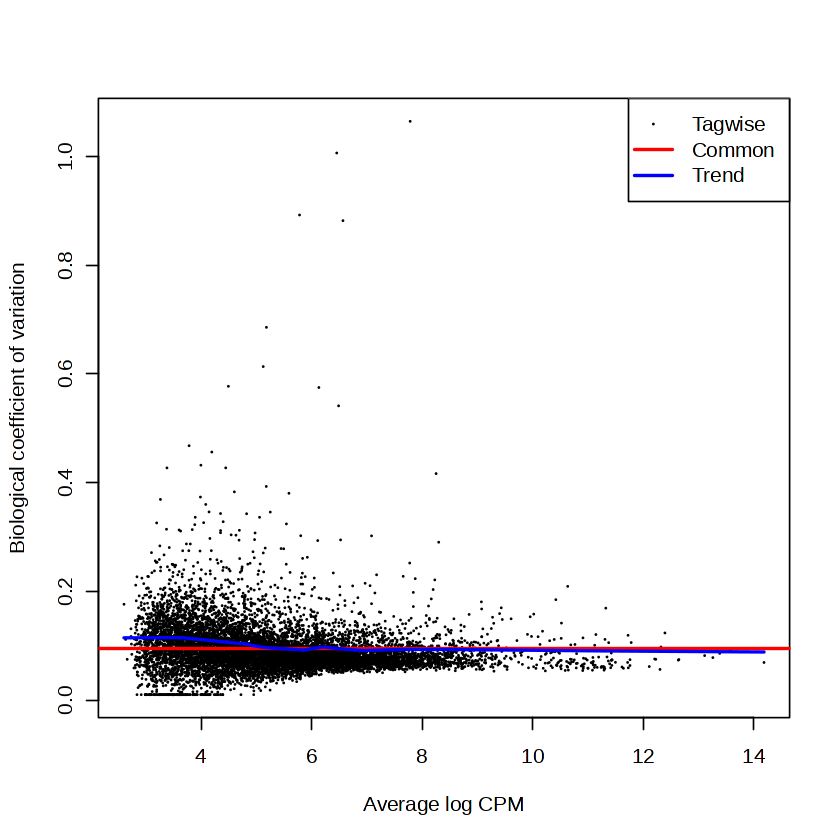

In [20]:
plotBCV(y)

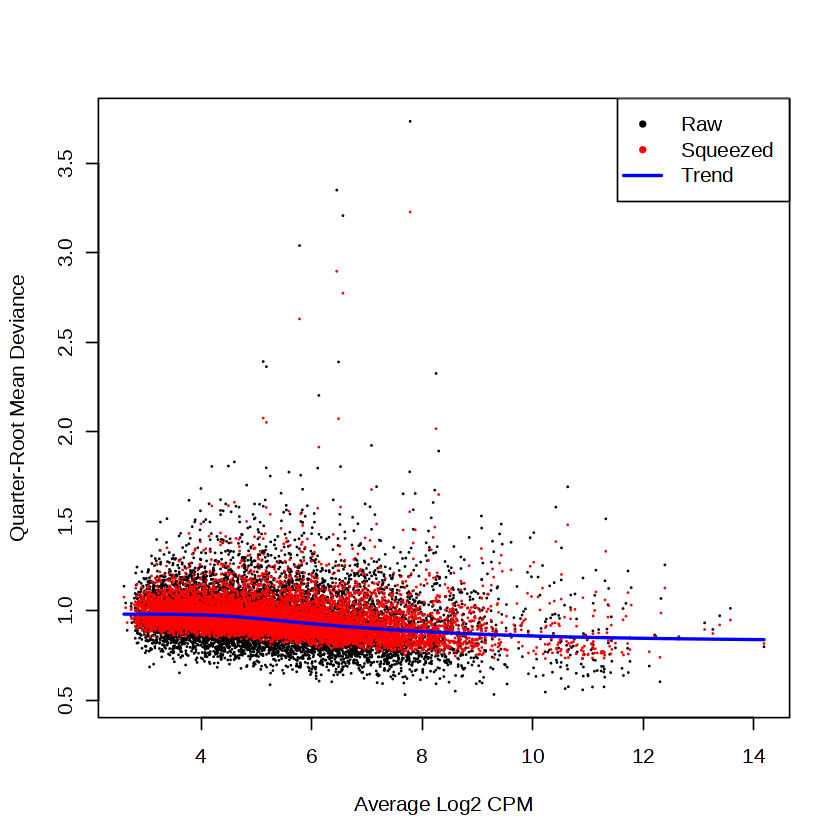

In [21]:
plotQLDisp(fit)

In [22]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Lm-VCT-Hrv135-1,Lm-VCT-Hrv135-2,Lm-VCT-Hrv135-3,Lm-VCT-Hrv136-1,Lm-VCT-Hrv136-2,Lm-VCT-Hrv136-3,Lm-VCT-Hrv236-1,Lm-VCT-Hrv236-2,Lm-VCT-Hrv236-3,UI-VCT-Hrv135-1,UI-VCT-Hrv135-2,UI-VCT-Hrv135-3,UI-VCT-Hrv136-1,UI-VCT-Hrv136-2,UI-VCT-Hrv136-3,UI-VCT-Hrv236-1,UI-VCT-Hrv236-2,UI-VCT-Hrv236-3
TIMP1,498.11683,480.137444,492.805114,438.57449,422.74197,428.00471,112.615932,162.024972,110.101690,257.080810,260.265982,251.948014,263.075003,252.527252,250.364113,79.9543016,91.69182,71.1300693
CXCL8,154.23240,163.091406,182.520412,163.07273,137.24288,138.56441,172.371324,187.305464,211.494771,120.397574,99.888863,101.229113,97.290443,91.659996,89.924696,106.7172478,92.41097,113.8081109
CIB2,18.83070,15.532515,11.614935,18.23173,18.42613,14.96689,8.043995,8.043793,10.574739,38.969263,32.741350,29.993811,34.349903,32.226281,34.397425,16.3923045,17.97879,17.4776742
GJA5,95.94690,112.839152,104.119599,107.87109,109.28600,104.52681,80.439951,62.626673,87.086082,151.805637,158.712305,196.459464,153.237590,178.301145,159.948025,121.7714050,112.54721,109.7435355
IL1B,26.00430,27.410320,23.644690,24.05576,20.75587,16.65670,25.281128,40.793521,38.566694,10.469354,8.324072,8.248298,7.816146,6.075446,7.862269,20.4067464,17.25964,18.6970468
SERPINF1,234.48704,282.783138,276.684353,249.42025,270.46167,275.68041,218.911582,233.844551,234.510379,394.927308,386.791875,369.673724,350.698108,326.489208,333.900716,325.8388693,320.38200,338.1726724
CLIP4,77.56455,78.119413,76.326718,75.45912,68.62144,73.86883,88.483946,93.652732,85.841995,50.020248,53.274060,52.489170,44.428617,45.697923,49.876266,63.8965339,71.55557,63.0009185
ZFP36L1,300.84284,274.103203,343.885050,308.16695,320.02160,337.96198,693.507294,658.441906,590.319229,184.376961,192.563530,208.456988,265.337571,238.527310,240.536277,456.9773055,438.32284,457.6711889
ADAM12,175.30484,169.943986,237.691355,222.83231,220.68995,186.84469,256.833273,298.194894,355.808850,72.122218,68.257390,59.987622,110.660165,84.527950,111.545935,176.6354446,229.76891,180.8736048
SLC27A2,111.19080,127.001151,129.838384,157.50193,141.90237,173.08481,99.400797,105.718421,111.967820,201.244254,190.343778,170.214879,253.201977,240.112209,238.570710,144.8544460,141.67285,123.5630918


In [23]:
summary(decideTests(qlf))

       summed_celltype$infectionLm
Down                           957
NotSig                        7509
Up                            1044

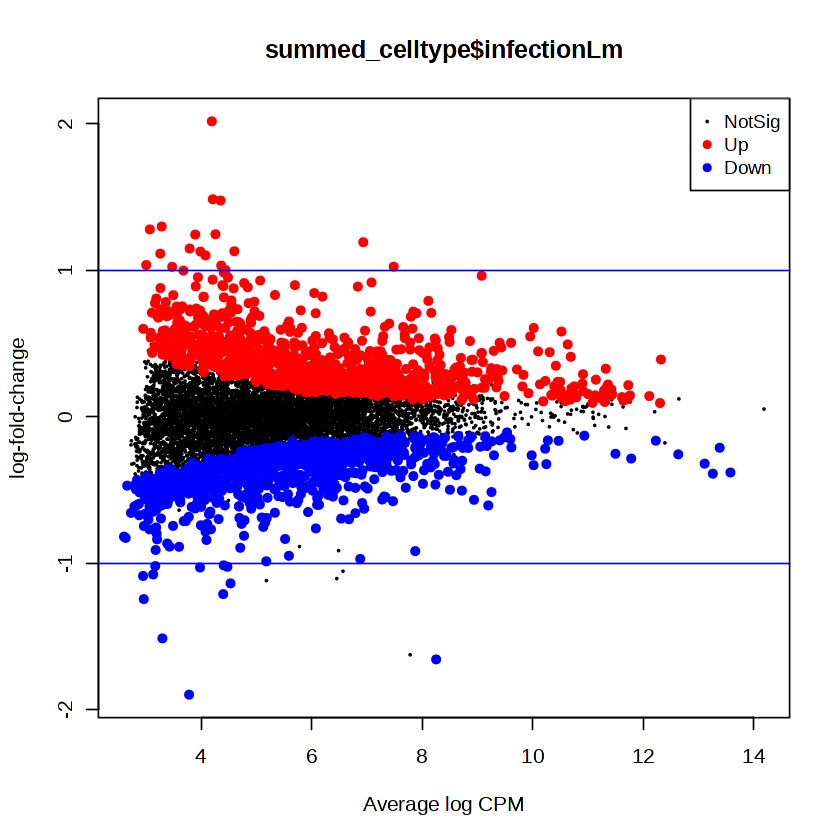

In [24]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

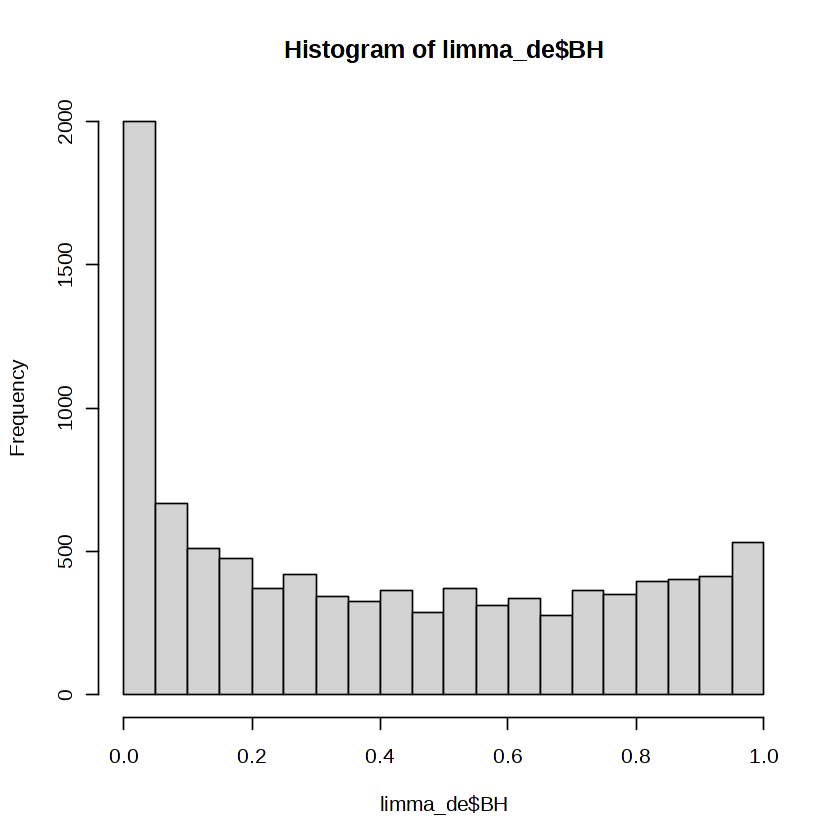

In [26]:

hist(limma_de$BH)

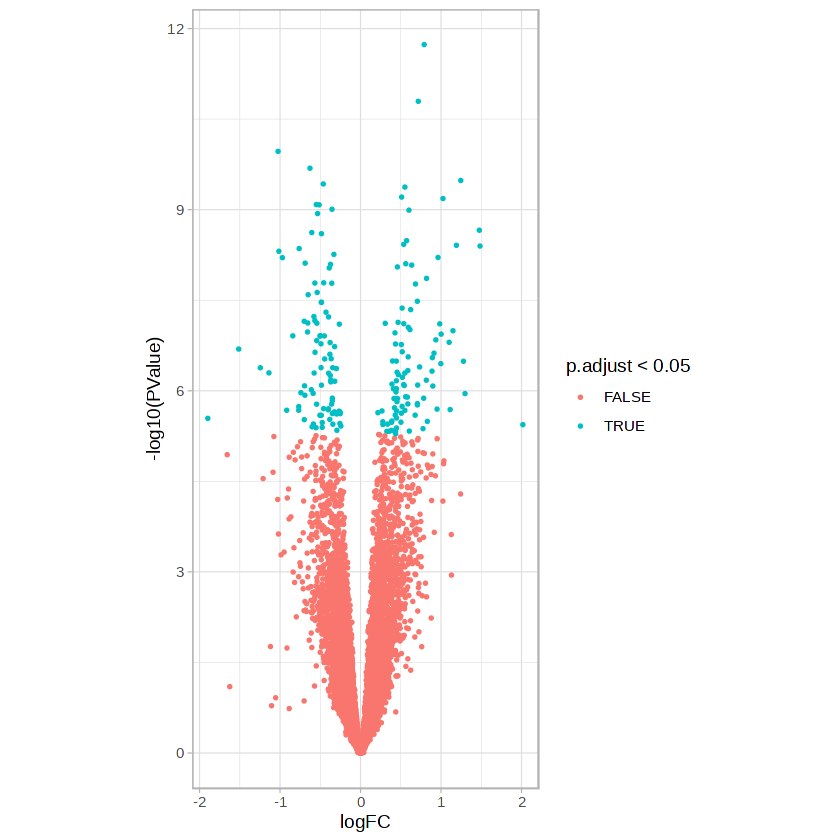

In [27]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = bonferroni < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

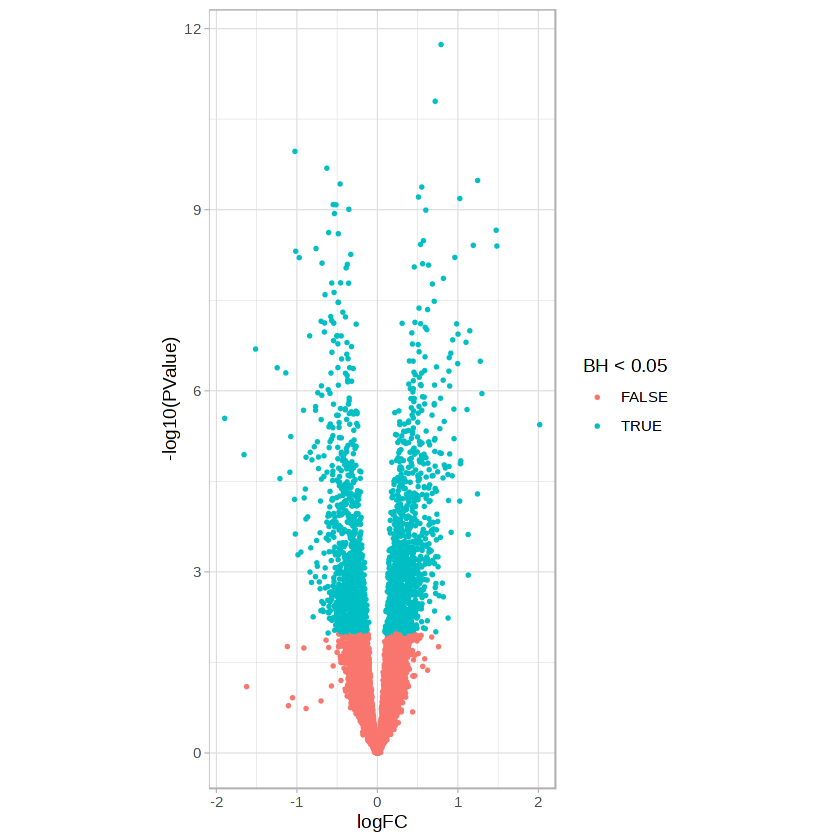

In [28]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
